# Interoperability with `scirpy`
![dandelion_logo](img/dandelion_logo_illustration.png)

It is now possible to convert the file formats between `dandelion>=0.1.1` and `scirpy>=0.6.2` [[Sturm2020]](https://academic.oup.com/bioinformatics/article/36/18/4817/5866543) to enhance the collaboration between the analysis toolkits.

We will download the *airr_rearrangement.tsv* file from here:
```bash
# bash
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_airr_rearrangement.tsv
```


**Import *dandelion* module**

In [1]:
import os
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))
ddl.logging.print_versions()

dandelion==0.2.4.dev78 pandas==1.4.2 numpy==1.21.6 matplotlib==3.5.2 networkx==2.8.4 scipy==1.8.1


In [2]:
import scirpy as ir
ir.__version__

'0.10.2.dev28+g2c5b99e'

## `dandelion`

In [3]:
# read in the airr_rearrangement.tsv file
file_location = 'sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_airr_rearrangement.tsv'
vdj = ddl.read_10x_airr(file_location)
vdj

Dandelion class object with n_obs = 994 and n_contigs = 2093
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'rearrangement_status'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_B_VJ', 'j_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_count_B_VJ', 'isotype', 'isotyp

The test file contains a blank `clone_id` column so we run `find_clones` to populate it first.

In [4]:
ddl.tl.find_clones(vdj)

Finding clones based on B cell VDJ chains : 100%|██████████| 157/157 [00:00<00:00, 2160.72it/s]                                                  
Refining clone assignment based on VJ chain pairing : 100%|██████████| 978/978 [00:00<00:00, 245058.21it/s]                                      


### `ddl.to_scirpy` : Converting `dandelion` to `scirpy`

In [5]:
irdata = ddl.to_scirpy(vdj)
irdata

/Users/kt16/Documents/Github/scirpy/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 994 × 0
    obs: 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir'
    uns: 'scirpy_version'

to transfer every column found in a dandelion airr object (including things like `germline_alignment_d_mask`) do:

In [6]:
irdata = ddl.to_scirpy(vdj, include_fields = vdj.data.columns)
irdata

/Users/kt16/Documents/Github/scirpy/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 994 × 0
    obs: 'is_cell', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_c_cigar', 'IR_VJ_2_c_cigar', 'IR_VDJ_1_c_cigar', 'IR_VDJ_2_c_cigar', 'IR_VJ_1_c_sequence_end', 'IR_VJ_2_c_sequence_end', 'IR_VDJ_1_c_sequence_end', 'IR_VDJ_2_c_sequence_end', 'IR_VJ_1_c_sequence_start', 'IR_VJ_2_c_sequence_start', 'IR_VDJ_1_c_sequence_start', 'IR_VDJ_2_c_sequence_start', 'IR_VJ_1_clone_id', 'IR_VJ_2_clone_id', 'IR_VDJ_1_clone_id', 'IR_VDJ_2_clone_id', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_d_cigar', 'IR_VJ_2_d_cigar', 'IR_VDJ_1_d_cigar', 'IR_VDJ_2_d_cigar', 'IR_VJ_1_d_sequence_end', 'IR_VJ_2_d_sequence_end', 'IR_VDJ_1_d_sequence_end', 'IR_VDJ_2_d_sequence_end', 'IR_VJ_1_d_sequence_start', 'IR_VJ_2_d_sequence_start', 'IR_VDJ_1_d_sequence_start

The `clone_id` is mapped to `IR_VJ_1_clone_id` column.

`transfer = True` will perform dandelion's `tl.transfer`.

In [7]:
irdatax = ddl.to_scirpy(vdj, transfer = True)
irdatax

/Users/kt16/Documents/Github/scirpy/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 994 × 0
    obs: 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_V

### `ddl.from_scirpy` : Converting `scirpy` to `dandelion`

In [8]:
vdjx = ddl.from_scirpy(irdata)
vdjx

Dandelion class object with n_obs = 994 and n_contigs = 2093
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'c_call', 'c_cigar', 'c_sequence_end', 'c_sequence_start', 'clone_id', 'consensus_count', 'd_sequence_end', 'd_sequence_start', 'duplicate_count', 'j_sequence_end', 'j_sequence_start', 'junction_aa_length', 'junction_length', 'locus', 'rearrangement_status', 'sequence_aa', 'v_sequence_end', 'v_sequence_start', 'cell_id', 'multi_chain', 'is_cell'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_B_VJ', 'j_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplica

In [9]:
vdjx.metadata

,clone_id,clone_id_by_size,locus_VDJ,locus_VJ,productive_VDJ,productive_VJ,v_call_VDJ,d_call_VDJ,j_call_VDJ,v_call_VJ,...,productive_B_VDJ,productive_B_VJ,duplicate_count_B_VDJ,duplicate_count_B_VJ,isotype,isotype_status,locus_status,chain_status,rearrangement_status_VDJ,rearrangement_status_VJ
AAACCTGTCATATCGG-1,None,None,None,IGK,None,True,None,None,None,IGKV1-8,...,None,True,NaN,68.0,None,None,Orphan IGK,Orphan VJ,None,standard
AAACCTGTCCGTTGTC-1,B_40_3_1_79_2_1,949,IGH,IGK,True,True,IGHV1-69D,IGHD3-22,IGHJ3,IGKV1-8,...,True,True,51.0,43.0,IgM,IgM,IGH + IGK,Single pair,standard,standard
AAACCTGTCGAGAACG-1,B_51_4_1_60_1_1,766,IGH,IGL,True,True,IGHV1-2,None,IGHJ3,IGLV5-45,...,True,True,47.0,90.0,IgM,IgM,IGH + IGL,Single pair,standard,standard
AAACCTGTCTTGAGAC-1,B_110_1_1_20_1_1,765,IGH,IGK,True,True,IGHV5-51,None,IGHJ3,IGKV1D-8,...,True,True,80.0,22.0,IgM,IgM,IGH + IGK,Single pair,standard,standard
AAACGGGAGCGACGTA-1,B_79_1_1_48_2_3,764,IGH,IGL,True,True,IGHV4-59,None,IGHJ3,IGLV3-19,...,True,True,18.0,14.0,IgM,IgM,IGH + IGL,Single pair,standard,standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCTCTAACGGT-1,B_9_3_1_117_1_1,383,IGH,IGL,True,True,IGHV3-43,None,IGHJ6,IGLV2-8,...,True,True,46.0,163.0,IgM,IgM,IGH + IGL,Single pair,standard,standard
TTTGGTTGTAGCCTAT-1,B_109_1_1_102_2_1,382,IGH,IGK,True,True,IGHV4-39,None,IGHJ2,IGKV6-21,...,True,True,5.0,6.0,IgM,IgM,IGH + IGK,Single pair,standard,standard
TTTGGTTTCAGAGCTT-1,B_14_5_1_105_1_1,381,IGH,IGK,True,True,IGHV7-4-1,IGHD3-10,IGHJ4,IGKV3-11,...,True,True,73.0,73.0,IgM,IgM,IGH + IGK,Single pair,standard,standard
TTTGGTTTCAGTGTTG-1,B_1_1_1_38_2_1,380,IGH,IGL,True,True,IGHV2-5,None,IGHJ4,IGLV2-23,...,True,True,33.0,58.0,IgM,IgM,IGH + IGL,Single pair,standard,standard


## `scirpy`

### `ir.io.from_dandelion` : Converting `dandelion` to `scirpy`

In [10]:
irdata2 = ir.io.from_dandelion(vdj, include_fields = vdj.data.columns)
irdata2

/Users/kt16/Documents/Github/scirpy/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 994 × 0
    obs: 'is_cell', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_c_cigar', 'IR_VJ_2_c_cigar', 'IR_VDJ_1_c_cigar', 'IR_VDJ_2_c_cigar', 'IR_VJ_1_c_sequence_end', 'IR_VJ_2_c_sequence_end', 'IR_VDJ_1_c_sequence_end', 'IR_VDJ_2_c_sequence_end', 'IR_VJ_1_c_sequence_start', 'IR_VJ_2_c_sequence_start', 'IR_VDJ_1_c_sequence_start', 'IR_VDJ_2_c_sequence_start', 'IR_VJ_1_clone_id', 'IR_VJ_2_clone_id', 'IR_VDJ_1_clone_id', 'IR_VDJ_2_clone_id', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_d_cigar', 'IR_VJ_2_d_cigar', 'IR_VDJ_1_d_cigar', 'IR_VDJ_2_d_cigar', 'IR_VJ_1_d_sequence_end', 'IR_VJ_2_d_sequence_end', 'IR_VDJ_1_d_sequence_end', 'IR_VDJ_2_d_sequence_end', 'IR_VJ_1_d_sequence_start', 'IR_VJ_2_d_sequence_start', 'IR_VDJ_1_d_sequence_start

likewise, `transfer = True` will perform dandelion's `tl.transfer`.

In [11]:
irdata2x = ir.io.from_dandelion(vdj, transfer = True, include_fields = vdj.data.columns)
irdata2x

/Users/kt16/Documents/Github/scirpy/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 994 × 0
    obs: 'is_cell', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_c_cigar', 'IR_VJ_2_c_cigar', 'IR_VDJ_1_c_cigar', 'IR_VDJ_2_c_cigar', 'IR_VJ_1_c_sequence_end', 'IR_VJ_2_c_sequence_end', 'IR_VDJ_1_c_sequence_end', 'IR_VDJ_2_c_sequence_end', 'IR_VJ_1_c_sequence_start', 'IR_VJ_2_c_sequence_start', 'IR_VDJ_1_c_sequence_start', 'IR_VDJ_2_c_sequence_start', 'IR_VJ_1_clone_id', 'IR_VJ_2_clone_id', 'IR_VDJ_1_clone_id', 'IR_VDJ_2_clone_id', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_d_cigar', 'IR_VJ_2_d_cigar', 'IR_VDJ_1_d_cigar', 'IR_VDJ_2_d_cigar', 'IR_VJ_1_d_sequence_end', 'IR_VJ_2_d_sequence_end', 'IR_VDJ_1_d_sequence_end', 'IR_VDJ_2_d_sequence_end', 'IR_VJ_1_d_sequence_start', 'IR_VJ_2_d_sequence_start', 'IR_VDJ_1_d_sequence_start

### `ir.io.to_dandelion` : Converting `scirpy` to `dandelion`

In [12]:
vdj3 = ir.io.to_dandelion(irdata2)
vdj3

Dandelion class object with n_obs = 994 and n_contigs = 2093
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'c_call', 'c_cigar', 'c_sequence_end', 'c_sequence_start', 'clone_id', 'consensus_count', 'd_sequence_end', 'd_sequence_start', 'duplicate_count', 'j_sequence_end', 'j_sequence_start', 'junction_aa_length', 'junction_length', 'locus', 'rearrangement_status', 'sequence_aa', 'v_sequence_end', 'v_sequence_start', 'cell_id', 'multi_chain', 'is_cell'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_B_VJ', 'j_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplica

### Example of reading with `scirpy` followed by conversion to `dandelion`

In [13]:
# read in the airr_rearrangement.tsv file
file_location = 'sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_airr_rearrangement.tsv'
irdata_s = ir.io.read_airr(file_location)
irdata_s

/Users/kt16/Documents/Github/scirpy/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 994 × 0
    obs: 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir'
    uns: 'scirpy_version'

This time, find clones with `scirpy`'s method.

In [14]:
ir.tl.chain_qc(irdata_s)
ir.pp.ir_dist(irdata_s, metric = 'hamming', sequence="aa")
ir.tl.define_clonotypes(irdata_s)
irdata_s

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/984 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 994 × 0
    obs: 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'receptor_type', 'receptor_subtype', 'chain_pairing',

In [15]:
vdj4 = ir.io.to_dandelion(irdata_s)
vdj4

Dandelion class object with n_obs = 994 and n_contigs = 2093
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'c_call', 'consensus_count', 'duplicate_count', 'locus', 'cell_id', 'multi_chain', 'receptor_subtype', 'clone_id_size', 'receptor_type', 'chain_pairing', 'clone_id', 'rearrangement_status'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_B_VJ', 'j_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_count_B_VJ', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ'

### Visualising with `scirpy`'s plotting tools

You can now also plot `dandelion` networks using `scirpy`'s functions.

In [16]:
ddl.tl.generate_network(vdj, key = 'junction')

Setting up data: 2093it [00:00, 6822.11it/s]
Linking edges : 100%|██████████| 968/968 [00:00<00:00, 55905.57it/s]                                                                             


In [17]:
irdata_s.obs['scirpy_clone_id'] = irdata_s.obs['clone_id'] # stash it
ddl.tl.transfer(irdata_s, vdj, overwrite = True) # overwrite scirpy's clone_id definition

<AxesSubplot:>

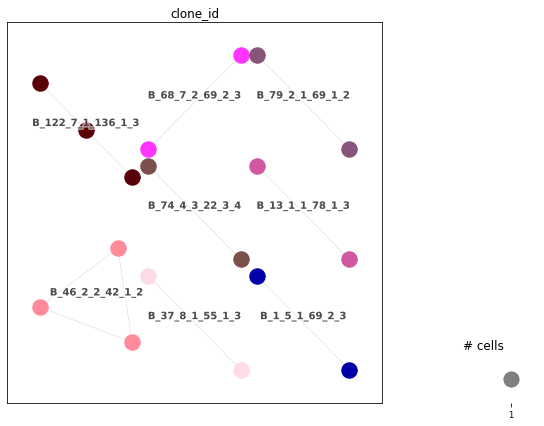

In [18]:
ir.tl.clonotype_network(irdata_s, min_cells = 2)
ir.pl.clonotype_network(irdata_s, color = 'clone_id', panel_size=(7,7))

to swap to a shorter clone_id name (ordered by size)

<AxesSubplot:>

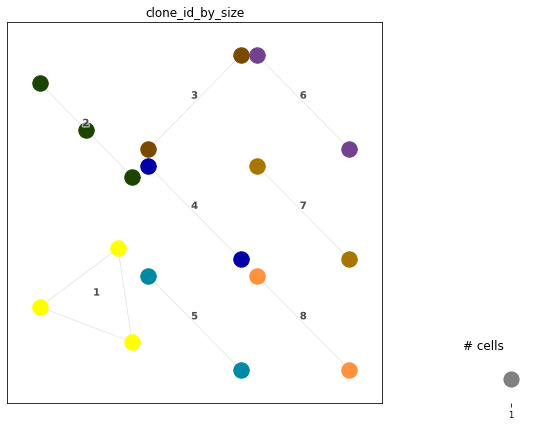

In [19]:
ddl.tl.transfer(irdata_s, vdj, clone_key = 'clone_id_by_size')
ir.tl.clonotype_network(irdata_s, clonotype_key= 'clone_id_by_size', min_cells = 2)
ir.pl.clonotype_network(irdata_s, color = 'clone_id_by_size', panel_size=(7,7))

you can also collapse the networks to a single node and plot by size

<AxesSubplot:>

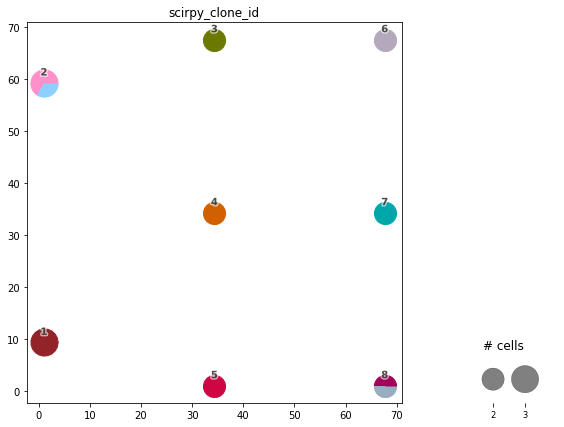

In [20]:
ddl.tl.transfer(irdata_s, vdj, clone_key = 'clone_id_by_size', collapse_nodes = True)
ir.tl.clonotype_network(irdata_s, clonotype_key = 'clone_id_by_size', min_cells = 2)
ir.pl.clonotype_network(irdata_s, color = 'scirpy_clone_id', panel_size=(7,7))